
### Recommendation systems:Collaborative Filtering: Memory-based and Model-based (Matrix Factorization) approach 
#### Edgar Acuna
#### March 2022
#### Database Movielens(100k), It contains the ratings given by 943 users to 1682 movies (items)
#### 

In [1]:
import warnings
warnings.filterwarnings("ignore")
from surprise import Reader, Dataset
import pandas as pd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
#Reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
url='https://files.grouplens.org/datasets/movielens/ml-100k/u.user'
users = pd.read_csv(url, sep='|', names=u_cols, encoding="ISO-8859-1")
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [3]:
len(users.user_id.unique())

943

### There are 943 users

In [4]:
#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
url='https://files.grouplens.org/datasets/movielens/ml-100k/u.data'
ratings = pd.read_csv(url, sep='\t', names=r_cols,encoding='latin-1')
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
print(ratings.shape)

(100000, 4)


### There are 100,00 ratings of 1682 movies by 943 users 

In [6]:
#Showing the ratings given by users to the movies in a cross table
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.tail()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
943,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#Reading items file where the category of the movie is included
i_cols = ['movie_id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
url='https://files.grouplens.org/datasets/movielens/ml-100k/u.item'
items = pd.read_csv(url, sep='|', names=i_cols,
encoding='latin-1')

In [8]:
items.head()

,movie_id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
print(len(items['movie title'].unique()))

1664


There are some movies with same title but different  id 

### 1-Item-based Recommendation system 

In [10]:
data1 = pd.merge(ratings, items.drop_duplicates(['movie_id']), on='movie_id') 
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             100000 non-null  int64  
 1   movie_id            100000 non-null  int64  
 2   rating              100000 non-null  int64  
 3   unix_timestamp      100000 non-null  int64  
 4   movie title         100000 non-null  object 
 5   release date        99991 non-null   object 
 6   video release date  0 non-null       float64
 7   IMDb URL            99987 non-null   object 
 8   unknown             100000 non-null  int64  
 9   Action              100000 non-null  int64  
 10  Adventure           100000 non-null  int64  
 11  Animation           100000 non-null  int64  
 12  Children's          100000 non-null  int64  
 13  Comedy              100000 non-null  int64  
 14  Crime               100000 non-null  int64  
 15  Documentary         100000 non-null

In [11]:
#Calculating the mean rating of all the movies
data1.groupby('movie title')['rating'].mean().sort_values(ascending=False).head(10) 

movie title
They Made Me a Criminal (1939)                       5.0
Marlene Dietrich: Shadow and Light (1996)            5.0
Saint of Fort Washington, The (1993)                 5.0
Someone Else's America (1995)                        5.0
Star Kid (1997)                                      5.0
Great Day in Harlem, A (1994)                        5.0
Aiqing wansui (1994)                                 5.0
Santa with Muscles (1996)                            5.0
Prefontaine (1997)                                   5.0
Entertaining Angels: The Dorothy Day Story (1996)    5.0
Name: rating, dtype: float64

In [12]:
# Calculate count rating of all movies 
data1.groupby('movie title')['rating'].count().sort_values(ascending=False).head(10) 

movie title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: rating, dtype: int64

Notice that none top-10 rated movie appears in the top 10 of movies with more count rating. 

Star Wars is in the 24th position among the highest rated picture. 

In [13]:
# Sorting values according to  the 'num of rating column' 
ratings1 = pd.DataFrame(data1.groupby('movie title')['rating'].mean())  
ratings1['num of ratings'] = pd.DataFrame(data1.groupby('movie title')['rating'].count()) 

In [14]:
#These are the top 10 movies with the highest number of ratings
ratings1.sort_values('num of ratings', ascending = False).head(10) 

,rating,num of ratings
movie title,,
Star Wars (1977),4.358491,583
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


In [15]:
#Building a cross table of user_id and movie title
moviemat = data1.pivot_table(index ='user_id', columns ='movie title', values ='rating') 
moviemat.shape

(943, 1664)

In [16]:
#Analyzing correlation with similar movies to Toys Story
toysstory_user_ratings = moviemat['Toy Story (1995)'] 
toysstory_user_ratings

user_id
1      5.0
2      4.0
3      NaN
4      NaN
5      4.0
      ... 
939    NaN
940    NaN
941    5.0
942    NaN
943    NaN
Name: Toy Story (1995), Length: 943, dtype: float64

In [17]:
similar_to_toystory = moviemat.corrwith(toysstory_user_ratings) 
corr_toystory = pd.DataFrame(similar_to_toystory, columns =['Correlation']) 
corr_toystory.dropna(inplace = True) 
  
corr_toystory.head(10) 

,Correlation
movie title,
'Til There Was You (1997),0.534522
101 Dalmatians (1996),0.232118
12 Angry Men (1957),0.334943
187 (1997),0.651857
2 Days in the Valley (1996),0.162728
"20,000 Leagues Under the Sea (1954)",0.328472
2001: A Space Odyssey (1968),-0.069060
"39 Steps, The (1935)",0.150055
8 1/2 (1963),-0.117259


In [18]:
# Similar movies like toy story but with more than 100 ratings
corr_toystory.sort_values('Correlation', ascending = False).head(10) 
corr_toystory = corr_toystory.join(ratings1['num of ratings']) 
  
corr_toystory.head() 
  
corr_toystory[corr_toystory['num of ratings']>100].sort_values('Correlation', ascending = False).head(10) 

,Correlation,num of ratings
movie title,,
Toy Story (1995),1.000000,452
"Craft, The (1996)",0.549100,104
Down Periscope (1996),0.457995,101
Miracle on 34th Street (1994),0.456291,101
G.I. Jane (1997),0.454756,175
Amistad (1997),0.449915,124
Beauty and the Beast (1991),0.442960,202
"Mask, The (1994)",0.432855,129
Cinderella (1950),0.428372,129


The  recommended movies  have different style compared to "Toys Story"

### 2.  Evaluating the peformance of RS by Collaborative Filtering

In [19]:
#Building the user-item matrix
n_users=943
n_items=1682
data_matrix = np.zeros((n_users, n_items))
for line in ratings.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]
data_matrix.shape

(943, 1682)

In [20]:
print(data_matrix)

[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]


In [21]:
#Computing the sparsity of the matrix (percentage of non-zero entries )
sparsity = float(len(data_matrix.nonzero()[0]))
sparsity /= (data_matrix.shape[0] * data_matrix.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity)) 

Sparsity: 6.30%


In this dataset, every user has rated at least 20 movies which results in a reasonable sparsity of 6.3%. This means that 6.3% of the user-item ratings have a value. Note that, although we filled in missing ratings as 0, we should not assume these values to truly be zero. More appropriately, they are just empty entries.

We will split our data into training and test sets by removing 10 ratings per user from the training set and placing them in the test set.

In [22]:
#Building the training and test sets
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [23]:
train, test = train_test_split(data_matrix)

In [24]:
#Function to find similarity by user and by item using the cosine metric
def similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling division-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [25]:
#computing the similarity matrices using the cosine metric
#from sklearn.metrics.pairwise import pairwise_distances 
user_similarity = similarity(train, kind='user')
item_similarity = similarity(train, kind='item')

In [26]:
print(item_similarity[:4, :4])

[[1.         0.39378647 0.32548309 0.44993824]
 [0.39378647 1.         0.27775381 0.48908147]
 [0.32548309 0.27775381 1.         0.33465301]
 [0.44993824 0.48908147 0.33465301 1.        ]]


In [27]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [28]:
user_prediction = predict(train, user_similarity, type='user')
item_prediction = predict(train, item_similarity, type='item')

In [29]:
item_prediction.shape

(943, 1682)

In [30]:
item_prediction[:1,:10]

array([[1.16338061, 1.0616734 , 1.09716212, 1.072783  , 1.01863403,
        1.08087323, 1.14035535, 1.08282727, 1.10582883, 1.07057726]])

In [31]:
print(user_prediction[:4, :10])

[[ 2.54759197  0.99876137  0.70811238  1.52644928  0.72304324  0.39242277
   2.25630935  1.63182046  1.71559016  0.71872317]
 [ 1.68371878  0.25468004  0.22018978  0.59450704  0.16512876  0.01674041
   1.35536423  0.7053777   1.1630004   0.2995214 ]
 [ 1.06110146  0.17690963  0.13645797  0.45512828  0.13397048 -0.03189986
   1.01269908  0.49387857  0.80508291  0.17297147]
 [ 1.26576451  0.20361257  0.11074253  0.52752798  0.08983394 -0.08650174
   1.12559726  0.57179508  0.83888169  0.09795314]]


In [32]:
#Computing the MSE of predictions
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [33]:
print('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 8.6826173477035
Item-based CF MSE: 11.510089084001061


### 3. Top-k collaborative filtering

In [34]:
#Function to make predictions using usres or items, the cosine metric and k neighbors
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [35]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print('Top-k User-based CF MSE: ' + str(get_mse(pred,test)))

pred = predict_topk(data_matrix, item_similarity, kind='item', k=40)
print('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))

Top-k User-based CF MSE: 6.449371934972651
Top-k Item-based CF MSE: 5.782112859230681


In [36]:
k_array = [5, 15, 30, 50, 100, 150]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]

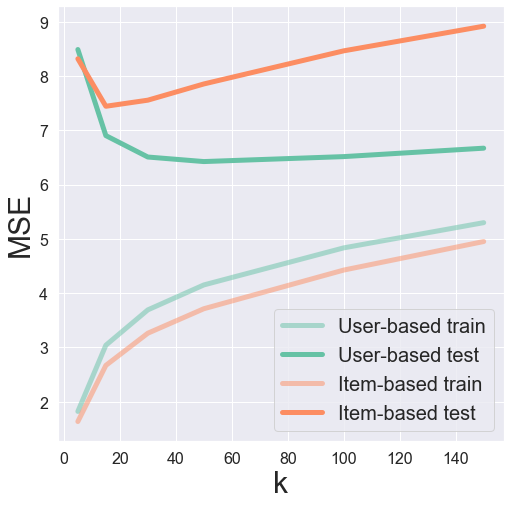

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

It looks like a k of 50 and 15 produces a  minimum in the test error for user- and item-based collaborative filtering, respectively.

### 3.1  Validation

In [38]:
# Load in movie data
url='https://files.grouplens.org/datasets/movielens/ml-100k/u.item'
idmovies = pd.read_csv(url,header= None,sep='|', encoding="ISO-8859-1")#with open('c://users/edgar2017/ml-100k/u.item', 'r') as f:

In [39]:
idx_to_movie=idmovies.loc[:,1]
idx_to_movie

0                                Toy Story (1995)
1                                GoldenEye (1995)
2                               Four Rooms (1995)
3                               Get Shorty (1995)
4                                  Copycat (1995)
                          ...                    
1677                            Mat' i syn (1997)
1678                             B. Monkey (1998)
1679                         Sliding Doors (1998)
1680                          You So Crazy (1994)
1681    Scream of Stone (Schrei aus Stein) (1991)
Name: 1, Length: 1682, dtype: object

In [40]:
#Recomendation using only 6 neighbors
def top_k_movies(similarity, mapper, movie_idx, k=6):
    return [mapper[x] for x in np.argsort(similarity[movie_idx,:])[:-k-1:-1]]

In [41]:
idx = 0 # Toy Story
movies = top_k_movies(item_similarity, idx_to_movie, idx)

In [42]:
movies

['Toy Story (1995)',
 'Star Wars (1977)',
 'Independence Day (ID4) (1996)',
 'Return of the Jedi (1983)',
 'Mission: Impossible (1996)',
 'Star Trek: First Contact (1996)']

Except by the rock, the recomendations are good

In [43]:
idx = 1 # Golden Eye
movies = top_k_movies(item_similarity, idx_to_movie, idx)
movies

['GoldenEye (1995)',
 'Under Siege (1992)',
 'Top Gun (1986)',
 'Batman (1989)',
 'True Lies (1994)',
 'Stargate (1994)']

Very good recoomendations

### 3.2 Replacing the cosine similarity measure by the Pearson correlation measure

In [44]:
from sklearn.metrics import pairwise_distances
# Convert from distance to similarity
item_correlation = 1 - pairwise_distances(train.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0.

In [45]:
idx = 0 # Toy Story
movies = top_k_movies(item_correlation, idx_to_movie, idx)
movies

['Toy Story (1995)',
 'Independence Day (ID4) (1996)',
 'Star Wars (1977)',
 'Mission: Impossible (1996)',
 'Willy Wonka and the Chocolate Factory (1971)',
 'Return of the Jedi (1983)']

In [46]:
idx = 1 # Golden Eye
movies = top_k_movies(item_correlation, idx_to_movie, idx)
movies

['GoldenEye (1995)',
 'Under Siege (1992)',
 'Top Gun (1986)',
 'Cliffhanger (1993)',
 'Stargate (1994)',
 'Batman (1989)']

In general good recommendations

### 4. Collaborative Filtering using Matrix Factorization and the module Surprise

In [151]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')
print(type(data))

<class 'surprise.dataset.DatasetAutoFolds'>


In [152]:
#Using the SVD algorithm
algo = SVD()

In [153]:
algo.fit(data.build_full_trainset())

In [154]:
#Predicting the rating given by the user number 10 to the item number 0
predictions = algo.predict(uid='10',iid='0')
score=predictions.est
print(score)

3.7977230281555863


In [155]:
# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9413  0.9375  0.9313  0.9384  0.9339  0.9365  0.0035  
MAE (testset)     0.7406  0.7404  0.7361  0.7373  0.7355  0.7380  0.0021  
Fit time          4.15    3.88    4.28    3.63    3.44    3.88    0.31    
Test time         0.09    0.12    0.12    0.10    0.09    0.10    0.01    


{'test_rmse': array([0.94133043, 0.93746331, 0.93130423, 0.93840979, 0.93390745]),
 'test_mae': array([0.74056876, 0.7404309 , 0.73605565, 0.73734435, 0.73554798]),
 'fit_time': (4.1482226848602295,
  3.876877784729004,
  4.2836315631866455,
  3.632071018218994,
  3.4404571056365967),
 'test_time': (0.09194302558898926,
  0.11971378326416016,
  0.11588191986083984,
  0.1021738052368164,
  0.09399199485778809)}

In [157]:
# Train the algorithm on the trainset, and predict ratings for the testset
# sample random trainset and testset
# test set is made of 25% of the ratings.
from surprise import accuracy
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=.25)
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9364


0.936415464058154

In [205]:
#Printing predictions for first user
ped=pd.DataFrame(predictions)
#ped.sort_values(by=['uid'], ascending=True).head()
ped1=ped.loc[ped['uid']=='1']
#ped1
ped2 = ped1.sort_values(by=['r_ui'], ascending=False)
top10=ped2.head(10)
top11=top10['iid'].astype(int)

In [206]:
items[items['movie_id'].isin(top11)]

,movie_id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
15,16,French Twist (Gazon maudit) (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Gazon%20maudi...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
31,32,Crumb (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Crumb%20(1994),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41,42,Clerks (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Clerks%20(1994),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110,111,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
126,127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169,170,Cinema Paradiso (1988),01-Jan-1988,NaN,http://us.imdb.com/M/title-exact?Nuovo%20cinem...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
196,197,"Graduate, The (1967)",01-Jan-1967,NaN,"http://us.imdb.com/M/title-exact?Graduate,%20T...",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
220,221,Breaking the Waves (1996),15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Breaking%20th...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241,242,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
267,268,Chasing Amy (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Chasing+Amy+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [88]:
#Showing the ratings given by users to the movies in a cross table
#rating_est = ped.pivot(index = 'uid', columns ='iid', values = 'est').fillna(0)
#rating_est.head()

In [89]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [90]:
# First train an SVD algorithm on the movielens dataset.
data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# Then predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)
ped=pd.DataFrame(predictions)
ped.sort_values(by=['uid'], ascending=True).head()
#Showing the ratings given by users to the movies in a cross table
rating_est = ped.pivot(index = 'uid', columns ='iid', values = 'est').fillna(0)

In [91]:
top_n = get_top_n(predictions, n=10)
len(list(top_n.items()))
#pd.DataFrame(list(top_n.items()))

943

In [92]:
top_n = get_top_n(predictions, n=10)
top_n.items()
# Print the top-10 recommended items for each user in the test set
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

196 ['474', '318', '357', '427', '480', '484', '589', '408', '483', '56']
186 ['408', '603', '272', '169', '64', '134', '513', '657', '316', '69']
22 ['100', '12', '199', '98', '169', '179', '114', '272', '483', '520']
244 ['14', '127', '285', '124', '98', '137', '134', '511', '55', '408']
166 ['173', '493', '89', '50', '172', '181', '511', '100', '169', '479']
298 ['169', '408', '114', '480', '313', '272', '657', '478', '963', '223']
115 ['179', '134', '408', '515', '60', '135', '483', '59', '428', '647']
253 ['199', '174', '272', '169', '313', '178', '189', '651', '69', '211']
305 ['515', '114', '694', '488', '513', '487', '603', '657', '646', '615']
6 ['603', '179', '654', '60', '1449', '657', '709', '705', '251', '430']
62 ['178', '479', '198', '430', '251', '1142', '150', '316', '408', '223']
286 ['197', '923', '136', '657', '64', '318', '919', '694', '488', '320']
200 ['12', '134', '272', '498', '223', '480', '316', '408', '251', '513']
210 ['408', '178', '603', '64', '480', '318

In [211]:

# Then predict ratings for all pairs (u, i) that are NOT in the training set.
#predictions1 = algo.test([['10','0',None]])
predictions1=algo.test(testset)[:5]
ped1=pd.DataFrame(predictions1)
ped1.sort_values(by=['uid'], ascending=True).head()
#Showing the ratings given by users to the movies in a cross table
rating_est1 = ped1.pivot(index = 'uid', columns ='iid', values = 'est').fillna(0)

In [212]:
rating_est1

iid,300,388,678,794,82
uid,,,,,
339,0.000000,0.000000,0.000000,0.000000,3.653743
387,0.000000,0.000000,2.359012,0.000000,0.000000
450,0.000000,2.887437,0.000000,0.000000,0.000000
796,4.051298,0.000000,0.000000,0.000000,0.000000
878,0.000000,0.000000,0.000000,3.286766,0.000000
